## Compare IWP, r_ice and t_ice for different ice particle shapes

In [8]:
import os
import netCDF4 as nc
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

Read results

In [9]:
path = os.getenv('HOME') + '/code_richter_et_al/data_TCWret/'
fname_spheroids = path + "spheroids.nc"
fname_spheres = path + 'spheres.nc'
fname_aggregates = path + 'aggregates.nc'
fname_bulletrosette = path + 'bulletrosettes.nc'
fname_droxtals = path + 'droxtals.nc'
fname_hollowcol = path + 'hollowcols.nc'
fname_plates = path + 'plates.nc'
fname_solidcol = path + 'solidcols.nc'

def read_tcwret(fname_tcwret):
    with nc.Dataset(fname_tcwret) as f:
        seconds = f.variables['time_of_measurement'][:]
        lwp = f.variables['liquid_water_path'][:]
        iwp = f.variables['ice_water_path'][:]
        lwp_err = f.variables['liquid_water_path_error'][:]
        iwp_err = f.variables['ice_water_path_error'][:]
        rliq = f.variables['liquid_water_effective_droplet_radius'][:]
        rice = f.variables['ice_water_effective_droplet_radius'][:]
        drliq = f.variables['liquid_water_effective_droplet_radius_error'][:]
        drice = f.variables['ice_water_effective_droplet_radius_error'][:]
        red_chi_2 = f.variables['reduced_chi_2'][:]
        t_cw = f.variables['liquid_water_optical_depth'][:] + f.variables['ice_water_optical_depth'][:]
        t_liq = f.variables['liquid_water_optical_depth'][:]
        t_ice = f.variables['ice_water_optical_depth'][:]
        dt_liq = f.variables['liquid_water_optical_depth_error'][:]
        dt_ice = f.variables['ice_water_optical_depth_error'][:]
        dt_cw = dt_liq + dt_ice
        
    idx_valid = np.where((red_chi_2 <= 1.0) & (t_cw <= 6.0) & (lwp+iwp <= 200.0) & (rice <= 100) & (rliq <= 50))[0]
        
    return pd.DataFrame({'time': seconds[idx_valid], \
                         'ti(1)': t_ice[idx_valid], \
                         'dti(1)': dt_ice[idx_valid], \
                         'iwp(gm-2)': iwp[idx_valid], \
                         'diwp(gm-2)': iwp_err[idx_valid], \
                         'fi(1)': t_ice[idx_valid]/t_cw[idx_valid], \
                         'dfi(1)': np.abs(dt_ice[idx_valid]/t_cw[idx_valid]) + np.abs(dt_cw[idx_valid]*t_ice[idx_valid]/t_cw[idx_valid]**2), \
                         'rl(um)': rliq[idx_valid], \
                         'drl(um)': drliq[idx_valid], \
                         'ri(um)': rice[idx_valid], \
                         'dri(um)': drice[idx_valid]})

Calculate the intersection of more than two datasets by converting them into sets

In [10]:
def intersect(*arrays):
    sets = []
    for ii in arrays:
        sets.append(set(ii['time']))

    intersection_of_sets = sets[0]
    for ii in sets[1:]:
        intersection_of_sets = ii & intersection_of_sets
        
    return np.array(list(intersection_of_sets))

Compare ice effective radius

\begin{tabular}{|c|c|c|c|c|c|c|c|c|}
\tophline
& SPH & A & BR & D & HC & P & SC & SPO\\
\middlehline
SPH & 0.00 & 6.76 & 14.15 & 4.17 & 4.62 & 10.72 & 3.88 & 3.18 &
\middlehline
A & 6.76 & 0.00 & 12.14 & 6.76 & 5.60 & 9.50 & 6.58 & 6.86 &
\middlehline
BR & 14.15 & 12.14 & 0.00 & 13.78 & 12.89 & 14.52 & 13.45 & 13.84 &
\middlehline
D & 4.17 & 6.76 & 13.78 & 0.00 & 4.78 & 10.88 & 2.99 & 3.67 &
\middlehline
HC & 4.62 & 5.60 & 12.89 & 4.78 & 0.00 & 10.19 & 4.47 & 4.52 &
\middlehline
P & 10.72 & 9.50 & 14.52 & 10.88 & 10.19 & 0.00 & 10.84 & 11.07 &
\middlehline
SC & 3.88 & 6.58 & 13.45 & 2.99 & 4.47 & 10.84 & 0.00 & 3.56 &
\middlehline
SPO & 3.18 & 6.86 & 13.84 & 3.67 & 4.52 & 11.07 & 3.56 & 0.00 &
\middlehline


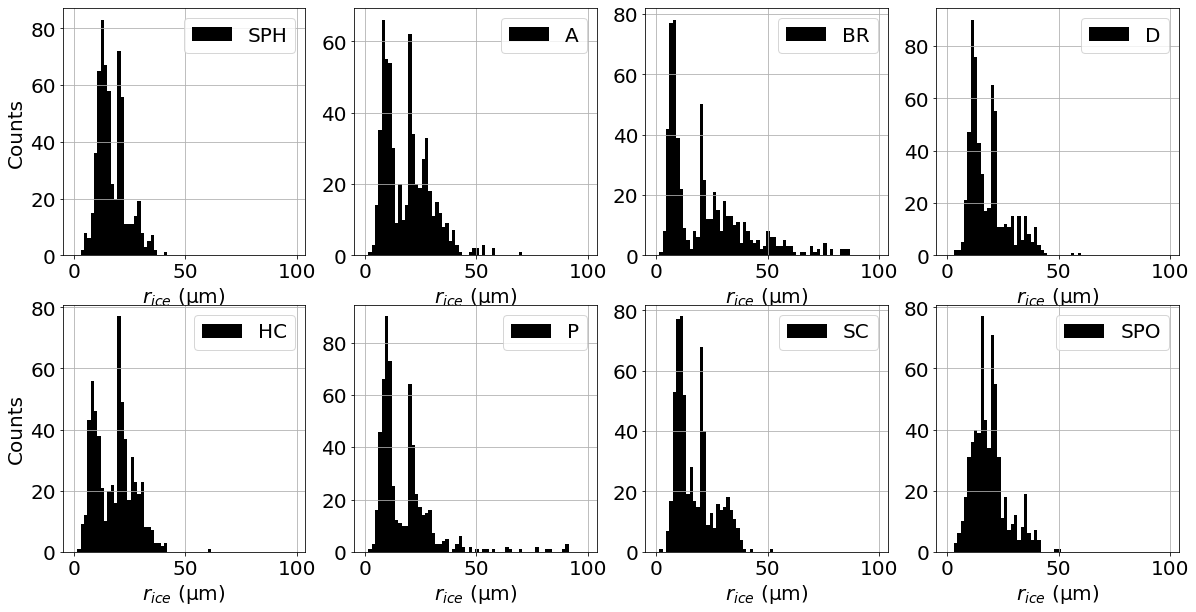

In [11]:
spheres = read_tcwret(fname_spheres)
spheroids = read_tcwret(fname_spheroids)
aggregates = read_tcwret(fname_aggregates)
bulletrosette = read_tcwret(fname_bulletrosette)
droxtals = read_tcwret(fname_droxtals)
hollowcol = read_tcwret(fname_hollowcol)
plates = read_tcwret(fname_plates)
solidcol = read_tcwret(fname_solidcol)

threshold = 0.1
idx_spheres = np.where(spheres['fi(1)'] > threshold)[0]
idx_aggregates = np.where(aggregates['fi(1)'] > threshold)[0]
idx_bulletrosette = np.where(bulletrosette['fi(1)'] > threshold)[0]
idx_droxtals = np.where(droxtals['fi(1)'] > threshold)[0]
idx_hollowcol = np.where(hollowcol['fi(1)'] > threshold)[0]
idx_plates = np.where(plates['fi(1)'] > threshold)[0]
idx_solidcol = np.where(solidcol['fi(1)'] > threshold)[0]
idx_spheroids = np.where(spheroids['fi(1)'] > threshold)[0]
spheres = spheres.iloc[idx_spheres]
aggregates = aggregates.iloc[idx_aggregates]
bulletrosette = bulletrosette.iloc[idx_bulletrosette]
droxtals = droxtals.iloc[idx_droxtals]
hollowcol = hollowcol.iloc[idx_hollowcol]
plates = plates.iloc[idx_plates]
solidcol = solidcol.iloc[idx_solidcol]
spheroids = spheroids.iloc[idx_spheroids]

times_intersect = intersect(spheres, spheroids, aggregates, bulletrosette, droxtals, hollowcol, plates, solidcol)
idx_spheres = np.intersect1d(spheres['time'], times_intersect, return_indices=True)[1]
idx_aggregates = np.intersect1d(aggregates['time'], times_intersect, return_indices=True)[1]
idx_bulletrosette = np.intersect1d(bulletrosette['time'], times_intersect, return_indices=True)[1]
idx_droxtals = np.intersect1d(droxtals['time'], times_intersect, return_indices=True)[1]
idx_hollowcol = np.intersect1d(hollowcol['time'], times_intersect, return_indices=True)[1]
idx_plates = np.intersect1d(plates['time'], times_intersect, return_indices=True)[1]
idx_solidcol = np.intersect1d(solidcol['time'], times_intersect, return_indices=True)[1]
idx_spheroids = np.intersect1d(spheroids['time'], times_intersect, return_indices=True)[1]

spheres = spheres.iloc[idx_spheres]
aggregates = aggregates.iloc[idx_aggregates]
bulletrosette = bulletrosette.iloc[idx_bulletrosette]
droxtals = droxtals.iloc[idx_droxtals]
hollowcol = hollowcol.iloc[idx_hollowcol]
plates = plates.iloc[idx_plates]
solidcol = solidcol.iloc[idx_solidcol]
spheroids = spheroids.iloc[idx_spheroids]

key = 'ri(um)'
a = np.array(spheres[key])
b = np.array(aggregates[key])
c = np.array(bulletrosette[key])
d = np.array(droxtals[key])
e = np.array(hollowcol[key])
f = np.array(plates[key])
g = np.array(solidcol[key])
h = np.array(spheroids[key])
key_err = 'dri(um)'
a_err = np.array(spheres[key_err])
b_err = np.array(aggregates[key_err])
c_err = np.array(bulletrosette[key_err])
d_err = np.array(droxtals[key_err])
e_err = np.array(hollowcol[key_err])
f_err = np.array(plates[key_err])
g_err = np.array(solidcol[key_err])
h_err = np.array(spheroids[key_err])
shapes_err = [a_err, b_err, c_err, d_err, e_err, f_err, g_err, h_err]
shapes = [a,b,c,d,e,f,g,h]
names=['Spheres', 'Aggregates', 'BulletRosette', 'Droxtals', 'HollowCol', 'Plates', 'SolidCol', 'Spheroids']
xlbl = r"Ice Effective Droplet Radius $r_{ice}$ ($\mathrm{\mu m}$)"
xlbl_short = r"$r_{ice}$ ($\mathrm{\mu m}$)"
bins = np.arange(0, 100, 1.5)
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
ax[0][0].hist(a, color="black", label="SPH", bins=bins)
ax[0][1].hist(b, color="black", label="A", bins=bins)
ax[0][2].hist(c, color="black", label="BR", bins=bins)
ax[0][3].hist(d, color="black", label="D", bins=bins)
ax[1][0].hist(e, color="black", label="HC", bins=bins)
ax[1][1].hist(f, color="black", label="P", bins=bins)
ax[1][2].hist(g, color="black", label="SC", bins=bins)
ax[1][3].hist(h, color="black", label="SPO", bins=bins)
fs = 20
for ii in range(2):
    ax[ii][0].set_ylabel("Counts", fontsize=fs)
    for jj in range(4):
        ax[ii][jj].legend(fontsize=fs)
        ax[ii][jj].grid(True)
        ax[ii][jj].set_xlabel(xlbl_short, fontsize=fs)
        ax[ii][jj].tick_params(labelsize=fs)
        
plt.savefig("rice.png", bbox_inches="tight")
        
print(r"\begin{tabular}{|c|c|c|c|c|c|c|c|c|}")
print(r"\tophline")
print(r"& SPH & A & BR & D & HC & P & SC & SPO\\")
print(r"\middlehline")
labels = ["SPH", "A", "BR", "D", "HC", "P", "SC", "SPO"]
for ii in range(len(shapes)):
    std = labels[ii] + " &"
    for jj in range(len(shapes)):
        std += ' {:.2f} &'.format(np.std(shapes[ii]-shapes[jj]))
    print(std + "\n" + r"\middlehline")

## Compare ice optical thickness

\begin{tabular}{|c|c|c|c|c|c|c|c|c|}
\tophline
& SPH & A & BR & D & HC & P & SC & SPO\\
\middlehline
SPH & 0.00 & 0.49 & 0.57 & 0.39 & 0.38 & 0.49 & 0.36 & 0.30 &
\middlehline
A & 0.49 & 0.00 & 0.39 & 0.43 & 0.41 & 0.36 & 0.41 & 0.47 &
\middlehline
BR & 0.57 & 0.39 & 0.00 & 0.51 & 0.47 & 0.37 & 0.52 & 0.55 &
\middlehline
D & 0.39 & 0.43 & 0.51 & 0.00 & 0.41 & 0.46 & 0.37 & 0.40 &
\middlehline
HC & 0.38 & 0.41 & 0.47 & 0.41 & 0.00 & 0.42 & 0.37 & 0.36 &
\middlehline
P & 0.49 & 0.36 & 0.37 & 0.46 & 0.42 & 0.00 & 0.41 & 0.48 &
\middlehline
SC & 0.36 & 0.41 & 0.52 & 0.37 & 0.37 & 0.41 & 0.00 & 0.36 &
\middlehline
SPO & 0.30 & 0.47 & 0.55 & 0.40 & 0.36 & 0.48 & 0.36 & 0.00 &
\middlehline


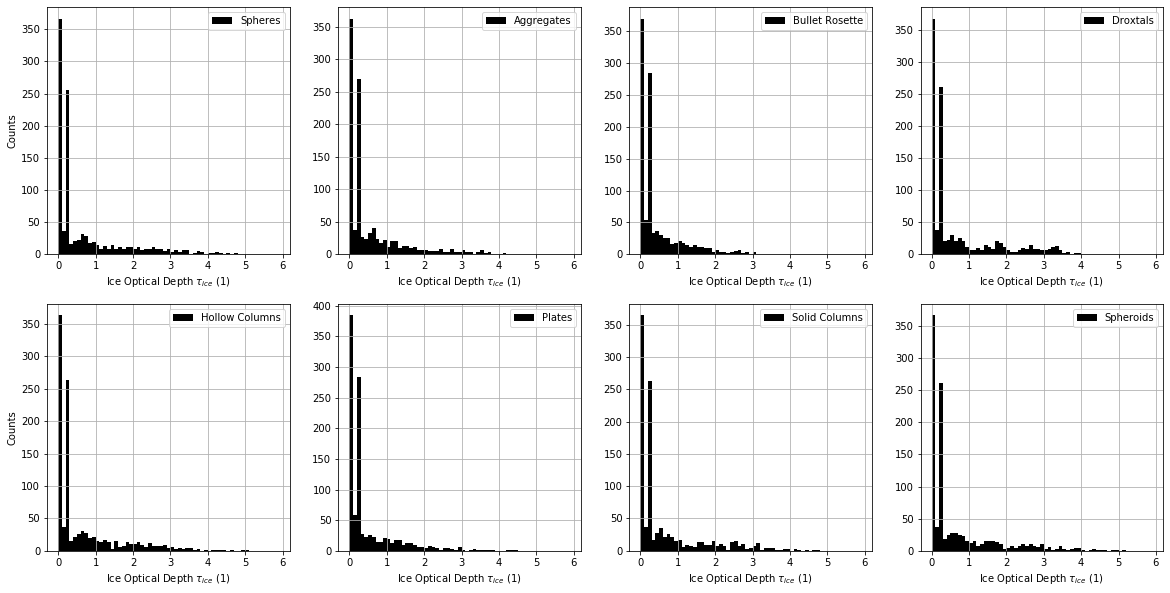

In [12]:
spheres = read_tcwret(fname_spheres)
spheroids = read_tcwret(fname_spheroids)
aggregates = read_tcwret(fname_aggregates)
bulletrosette = read_tcwret(fname_bulletrosette)
droxtals = read_tcwret(fname_droxtals)
hollowcol = read_tcwret(fname_hollowcol)
plates = read_tcwret(fname_plates)
solidcol = read_tcwret(fname_solidcol)

threshold = 0.0
idx_spheres = np.where(spheres['fi(1)'] > threshold)[0]
idx_aggregates = np.where(aggregates['fi(1)'] > threshold)[0]
idx_bulletrosette = np.where(bulletrosette['fi(1)'] > threshold)[0]
idx_droxtals = np.where(droxtals['fi(1)'] > threshold)[0]
idx_hollowcol = np.where(hollowcol['fi(1)'] > threshold)[0]
idx_plates = np.where(plates['fi(1)'] > threshold)[0]
idx_solidcol = np.where(solidcol['fi(1)'] > threshold)[0]
idx_spheroids = np.where(spheroids['fi(1)'] > threshold)[0]
spheres = spheres.iloc[idx_spheres]
aggregates = aggregates.iloc[idx_aggregates]
bulletrosette = bulletrosette.iloc[idx_bulletrosette]
droxtals = droxtals.iloc[idx_droxtals]
hollowcol = hollowcol.iloc[idx_hollowcol]
plates = plates.iloc[idx_plates]
solidcol = solidcol.iloc[idx_solidcol]
spheroids = spheroids.iloc[idx_spheroids]

times_intersect = intersect(spheres, spheroids, aggregates, bulletrosette, droxtals, hollowcol, plates, solidcol)
idx_spheres = np.intersect1d(spheres['time'], times_intersect, return_indices=True)[1]
idx_aggregates = np.intersect1d(aggregates['time'], times_intersect, return_indices=True)[1]
idx_bulletrosette = np.intersect1d(bulletrosette['time'], times_intersect, return_indices=True)[1]
idx_droxtals = np.intersect1d(droxtals['time'], times_intersect, return_indices=True)[1]
idx_hollowcol = np.intersect1d(hollowcol['time'], times_intersect, return_indices=True)[1]
idx_plates = np.intersect1d(plates['time'], times_intersect, return_indices=True)[1]
idx_solidcol = np.intersect1d(solidcol['time'], times_intersect, return_indices=True)[1]
idx_spheroids = np.intersect1d(spheroids['time'], times_intersect, return_indices=True)[1]

spheres = spheres.iloc[idx_spheres]
aggregates = aggregates.iloc[idx_aggregates]
bulletrosette = bulletrosette.iloc[idx_bulletrosette]
droxtals = droxtals.iloc[idx_droxtals]
hollowcol = hollowcol.iloc[idx_hollowcol]
plates = plates.iloc[idx_plates]
solidcol = solidcol.iloc[idx_solidcol]
spheroids = spheroids.iloc[idx_spheroids]


key = 'ti(1)'
a = np.array(spheres[key])
b = np.array(aggregates[key])
c = np.array(bulletrosette[key])
d = np.array(droxtals[key])
e = np.array(hollowcol[key])
f = np.array(plates[key])
g = np.array(solidcol[key])
h = np.array(spheroids[key])
key_err = 'dti(1)'
a_err = np.array(spheres[key_err])
b_err = np.array(aggregates[key_err])
c_err = np.array(bulletrosette[key_err])
d_err = np.array(droxtals[key_err])
e_err = np.array(hollowcol[key_err])
f_err = np.array(plates[key_err])
g_err = np.array(solidcol[key_err])
h_err = np.array(spheroids[key_err])
shapes_err = [a_err, b_err, c_err, d_err, e_err, f_err, g_err, h_err]
shapes = [a,b,c,d,e,f,g,h]
names=['Spheres', 'Aggregates', 'BulletRosette', 'Droxtals', 'HollowCol', 'Plates', 'SolidCol', 'Spheroids']
xlbl = r"Ice Optical Depth $\tau_{ice}$ ($1$)"
bins = np.arange(0, 6, 0.1)
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
ax[0][0].hist(a, color="black", label="Spheres", bins=bins)
ax[0][1].hist(b, color="black", label="Aggregates", bins=bins)
ax[0][2].hist(c, color="black", label="Bullet Rosette", bins=bins)
ax[0][3].hist(d, color="black", label="Droxtals", bins=bins)
ax[1][0].hist(e, color="black", label="Hollow Columns", bins=bins)
ax[1][1].hist(f, color="black", label="Plates", bins=bins)
ax[1][2].hist(g, color="black", label="Solid Columns", bins=bins)
ax[1][3].hist(h, color="black", label="Spheroids", bins=bins)

print(r"\begin{tabular}{|c|c|c|c|c|c|c|c|c|}")
print(r"\tophline")
print(r"& SPH & A & BR & D & HC & P & SC & SPO\\")
print(r"\middlehline")
labels = ["SPH", "A", "BR", "D", "HC", "P", "SC", "SPO"]
for ii in range(len(shapes)):
    std = labels[ii] + " &"
    for jj in range(len(shapes)):
        std += ' {:.2f} &'.format(np.std(shapes[ii]-shapes[jj]))
    print(std + "\n" + r"\middlehline")
    
for ii in range(2):
    ax[ii][0].set_ylabel("Counts")
    for jj in range(4):
        ax[ii][jj].legend()
        ax[ii][jj].grid(True)
        ax[ii][jj].set_xlabel(xlbl)

Compare ice water path

\begin{tabular}{|c|c|c|c|c|c|c|c|c|}
\tophline
& SPH & A & BR & D & HC & P & SC & SPO\\
\middlehline
SPH & 0.00 & 7.58 & 9.31 & 4.37 & 6.00 & 7.80 & 3.90 & 3.39 &
\middlehline
A & 7.58 & 0.00 & 8.32 & 7.08 & 6.80 & 7.29 & 7.04 & 7.79 &
\middlehline
BR & 9.31 & 8.32 & 0.00 & 9.13 & 8.85 & 9.13 & 9.08 & 9.72 &
\middlehline
D & 4.37 & 7.08 & 9.13 & 0.00 & 6.49 & 7.37 & 4.20 & 4.93 &
\middlehline
HC & 6.00 & 6.80 & 8.85 & 6.49 & 0.00 & 8.04 & 6.27 & 5.71 &
\middlehline
P & 7.80 & 7.29 & 9.13 & 7.37 & 8.04 & 0.00 & 6.99 & 8.45 &
\middlehline
SC & 3.90 & 7.04 & 9.08 & 4.20 & 6.27 & 6.99 & 0.00 & 4.43 &
\middlehline
SPO & 3.39 & 7.79 & 9.72 & 4.93 & 5.71 & 8.45 & 4.43 & 0.00 &
\middlehline


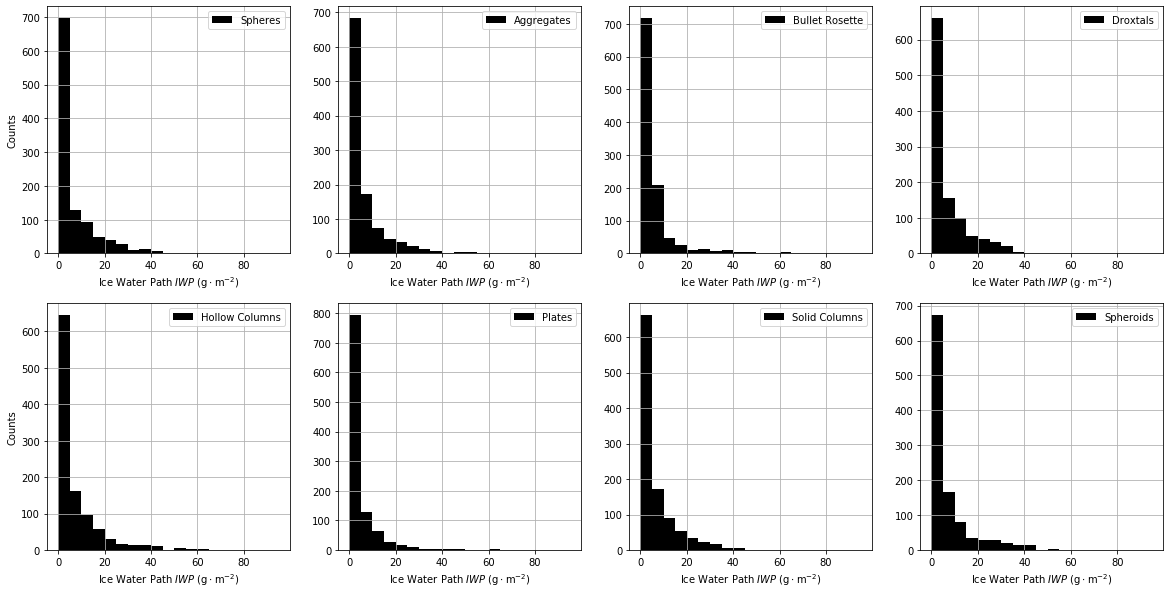

In [13]:
spheres = read_tcwret(fname_spheres)
spheroids = read_tcwret(fname_spheroids)
aggregates = read_tcwret(fname_aggregates)
bulletrosette = read_tcwret(fname_bulletrosette)
droxtals = read_tcwret(fname_droxtals)
hollowcol = read_tcwret(fname_hollowcol)
plates = read_tcwret(fname_plates)
solidcol = read_tcwret(fname_solidcol)

threshold = 0.0

idx_spheres = np.where(spheres['fi(1)'] > threshold)[0]
idx_aggregates = np.where(aggregates['fi(1)'] > threshold)[0]
idx_bulletrosette = np.where(bulletrosette['fi(1)'] > threshold)[0]
idx_droxtals = np.where(droxtals['fi(1)'] > threshold)[0]
idx_hollowcol = np.where(hollowcol['fi(1)'] > threshold)[0]
idx_plates = np.where(plates['fi(1)'] > threshold)[0]
idx_solidcol = np.where(solidcol['fi(1)'] > threshold)[0]
idx_spheroids = np.where(spheroids['fi(1)'] > threshold)[0]

spheres = spheres.iloc[idx_spheres]
aggregates = aggregates.iloc[idx_aggregates]
bulletrosette = bulletrosette.iloc[idx_bulletrosette]
droxtals = droxtals.iloc[idx_droxtals]
hollowcol = hollowcol.iloc[idx_hollowcol]
plates = plates.iloc[idx_plates]
solidcol = solidcol.iloc[idx_solidcol]
spheroids = spheroids.iloc[idx_spheroids]

times_intersect = intersect(spheres, spheroids, aggregates, bulletrosette, droxtals, hollowcol, plates, solidcol)
idx_spheres = np.intersect1d(spheres['time'], times_intersect, return_indices=True)[1]
idx_aggregates = np.intersect1d(aggregates['time'], times_intersect, return_indices=True)[1]
idx_bulletrosette = np.intersect1d(bulletrosette['time'], times_intersect, return_indices=True)[1]
idx_droxtals = np.intersect1d(droxtals['time'], times_intersect, return_indices=True)[1]
idx_hollowcol = np.intersect1d(hollowcol['time'], times_intersect, return_indices=True)[1]
idx_plates = np.intersect1d(plates['time'], times_intersect, return_indices=True)[1]
idx_solidcol = np.intersect1d(solidcol['time'], times_intersect, return_indices=True)[1]
idx_spheroids = np.intersect1d(spheroids['time'], times_intersect, return_indices=True)[1]

spheres = spheres.iloc[idx_spheres]
aggregates = aggregates.iloc[idx_aggregates]
bulletrosette = bulletrosette.iloc[idx_bulletrosette]
droxtals = droxtals.iloc[idx_droxtals]
hollowcol = hollowcol.iloc[idx_hollowcol]
plates = plates.iloc[idx_plates]
solidcol = solidcol.iloc[idx_solidcol]
spheroids = spheroids.iloc[idx_spheroids]

key = 'iwp(gm-2)'
a = np.array(spheres[key])
b = np.array(aggregates[key])
c = np.array(bulletrosette[key])
d = np.array(droxtals[key])
e = np.array(hollowcol[key])
f = np.array(plates[key])
g = np.array(solidcol[key])
h = np.array(spheroids[key])

key_err = 'diwp(gm-2)'
a_err = np.array(spheres[key_err])
b_err = np.array(aggregates[key_err])
c_err = np.array(bulletrosette[key_err])
d_err = np.array(droxtals[key_err])
e_err = np.array(hollowcol[key_err])
f_err = np.array(plates[key_err])
g_err = np.array(solidcol[key_err])
h_err = np.array(spheroids[key_err])
shapes_err = [a_err, b_err, c_err, d_err, e_err, f_err, g_err, h_err]
shapes = [a,b,c,d,e,f,g,h]
names=['Spheres', 'Aggregates', 'BulletRosette', 'Droxtals', 'HollowCol', 'Plates', 'SolidCol', 'Spheroids']
xlbl = r"Ice Water Path $IWP$ ($\mathrm{g \cdot m^{-2}}$)"
bins = np.arange(0, 100, 5)
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
ax[0][0].hist(a, color="black", label="Spheres", bins=bins)
ax[0][1].hist(b, color="black", label="Aggregates", bins=bins)
ax[0][2].hist(c, color="black", label="Bullet Rosette", bins=bins)
ax[0][3].hist(d, color="black", label="Droxtals", bins=bins)
ax[1][0].hist(e, color="black", label="Hollow Columns", bins=bins)
ax[1][1].hist(f, color="black", label="Plates", bins=bins)
ax[1][2].hist(g, color="black", label="Solid Columns", bins=bins)
ax[1][3].hist(h, color="black", label="Spheroids", bins=bins)

for ii in range(2):
    ax[ii][0].set_ylabel("Counts")
    for jj in range(4):
        ax[ii][jj].legend()
        ax[ii][jj].grid(True)
        ax[ii][jj].set_xlabel(xlbl)

print(r"\begin{tabular}{|c|c|c|c|c|c|c|c|c|}")
print(r"\tophline")
print(r"& SPH & A & BR & D & HC & P & SC & SPO\\")
print(r"\middlehline")
labels = ["SPH", "A", "BR", "D", "HC", "P", "SC", "SPO"]
for ii in range(len(shapes)):
    std = labels[ii] + " &"
    for jj in range(len(shapes)):
        std += ' {:.2f} &'.format(np.std(shapes[ii]-shapes[jj]))
    print(std + "\n" + r"\middlehline")